# Stock Market Price Prediction Using Machine Learning

### Importing required libraries

In [491]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics as sm
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Data Collection
#### Web-Scrapping Data from Yahoo Finance & Loading in DataFrame

In [492]:
symbol = input("Enter the symbol : ")

In [493]:
start = '1996-01-01'
end = datetime.now()

df = pdr.DataReader(symbol,'yahoo', start, end)
df.reset_index().head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,2.591785,2.390042,2.490664,2.499133,897427216.0,2.499133
1,2004-08-20,2.716817,2.503118,2.515820,2.697639,458857488.0,2.697639
2,2004-08-23,2.826406,2.716070,2.758411,2.724787,366857939.0,2.724787
3,2004-08-24,2.779581,2.579581,2.770615,2.611960,306396159.0,2.611960
4,2004-08-25,2.689918,2.587302,2.614201,2.640104,184645512.0,2.640104


In [494]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-26,100.440002,98.379997,98.610001,98.809998,22437900.0,98.809998
2022-09-27,100.459999,97.339996,99.910004,98.089996,24225000.0,98.089996
2022-09-28,101.400002,97.800003,98.019997,100.739998,24617000.0,100.739998
2022-09-29,99.300003,96.519997,99.300003,98.089996,21921500.0,98.089996
2022-09-30,99.494003,96.029999,97.730003,96.150002,26248200.0,96.150002


In [495]:
print("The shape of the Stock Price Dataset is: ",df.shape)

The shape of the Stock Price Dataset is:  (4562, 6)


### Exploratory Data Analysis

In [496]:
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [497]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4562.000000,4562.000000,4562.000000,4562.000000,4.562000e+03,4562.000000
mean,37.194307,36.448472,36.821908,36.827301,1.249512e+08,36.827301
std,35.169950,34.433772,34.797049,34.803337,1.541206e+08,34.803337
min,2.534002,2.390042,2.470490,2.490913,1.584340e+05,2.490913
25%,12.648839,12.370508,12.505813,12.497095,3.027100e+07,12.497095
50%,22.472518,22.135032,22.303775,22.330923,6.981333e+07,22.330923
75%,53.204687,51.998000,52.579251,52.603000,1.568598e+08,52.603000
max,152.100006,149.887497,151.863495,150.709000,1.650833e+09,150.709000


In [498]:
df['ma50'] = df.Close.rolling(50).mean()
df['ma200'] = df.Close.rolling(200).mean()

In [499]:
df['ema50'] = df.Close.ewm(span=50,adjust=False).mean()
df['ema200'] = df.Close.ewm(span=200,adjust=False).mean()

#### Visualizing Closing Price of the Stock

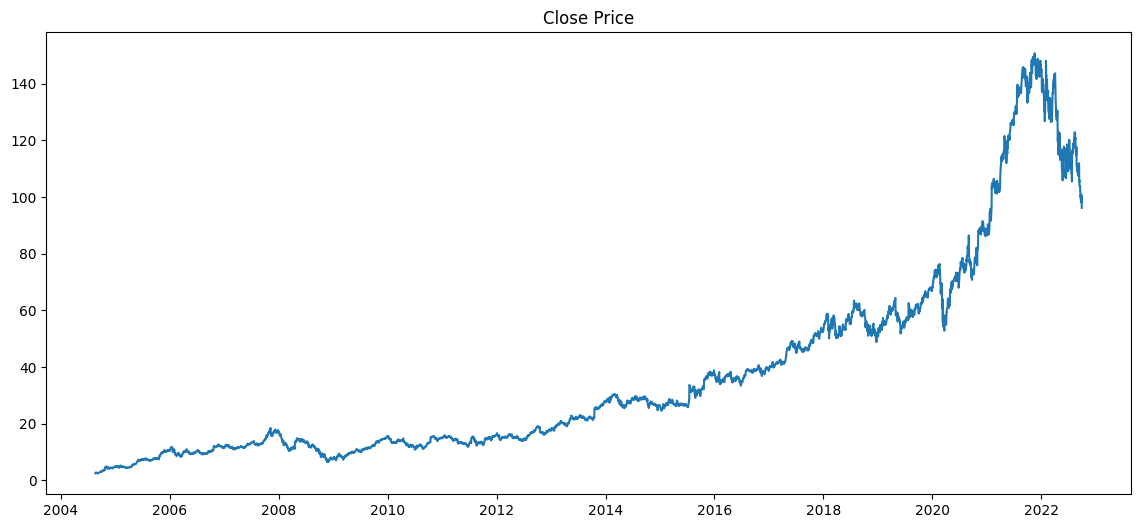

In [500]:
plt.figure(figsize=(14,6))
plt.title('Close Price')
plt.plot(df['Close'])

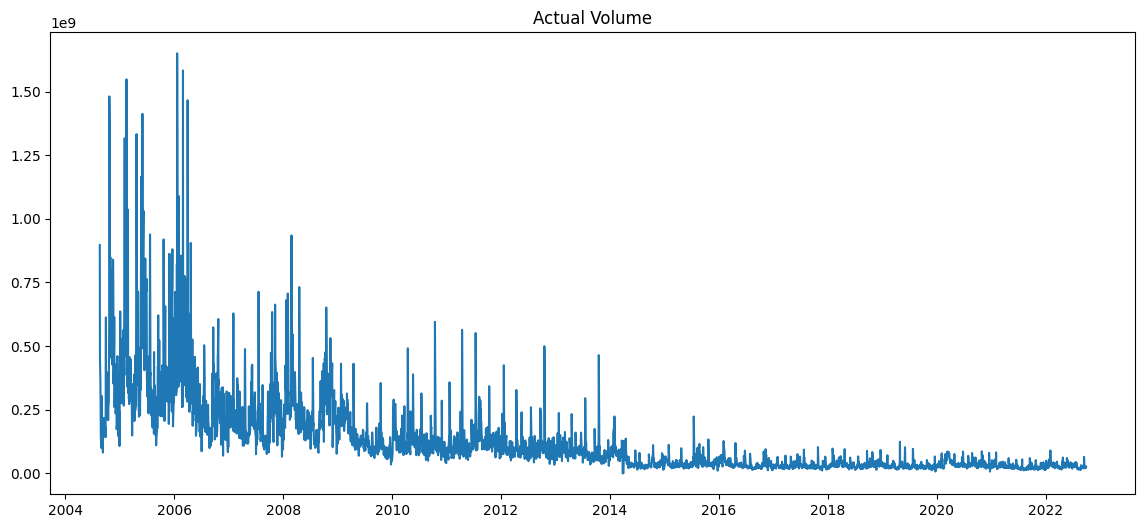

In [501]:
plt.figure(figsize=(14,6))
plt.title('Actual Volume')
plt.plot(df['Volume'])

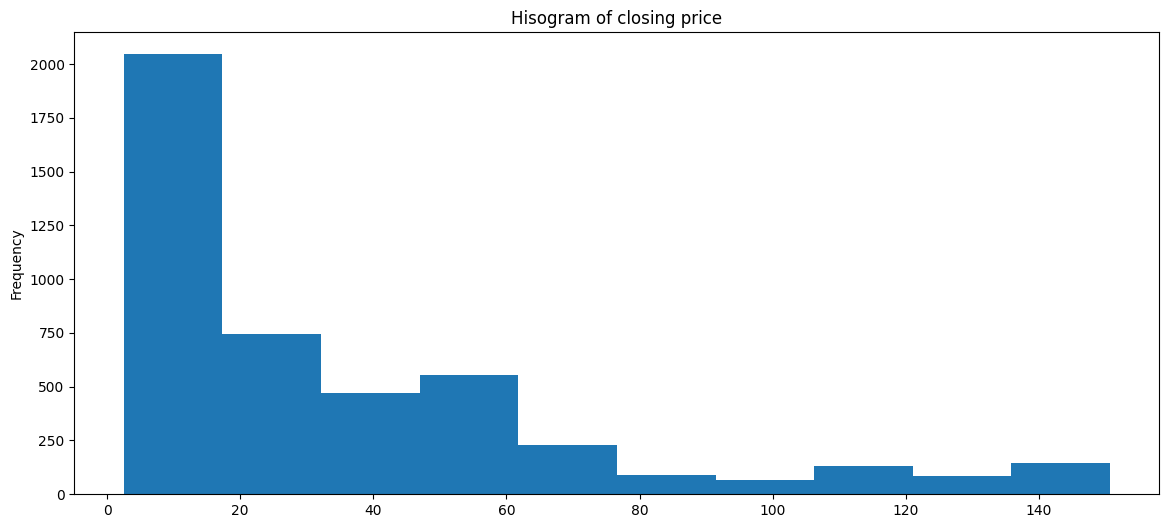

In [502]:
plt.figure(figsize=(14,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

<AxesSubplot: xlabel='Date'>

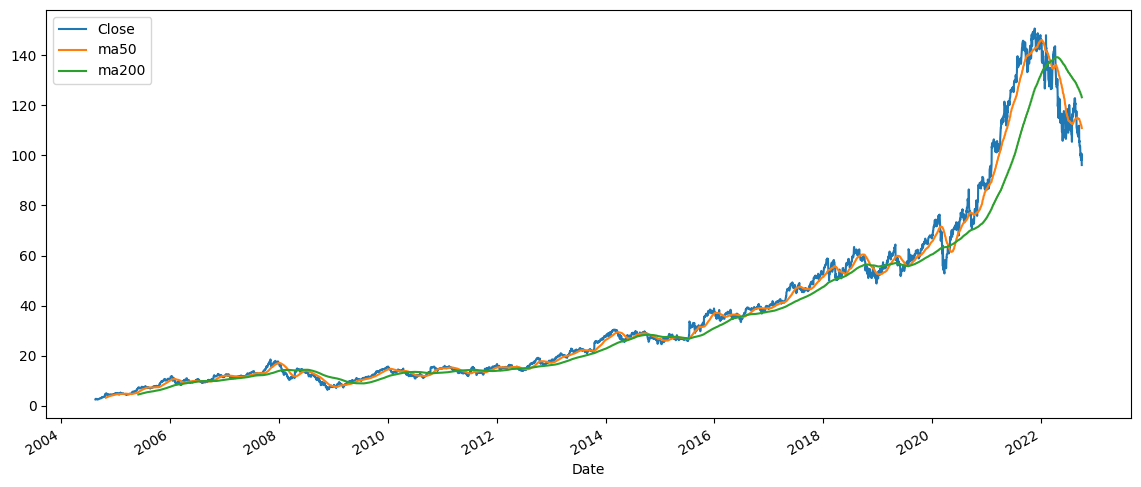

In [503]:
df[['Close','ma50','ma200']].plot(figsize=(14,6))

<AxesSubplot: xlabel='Date'>

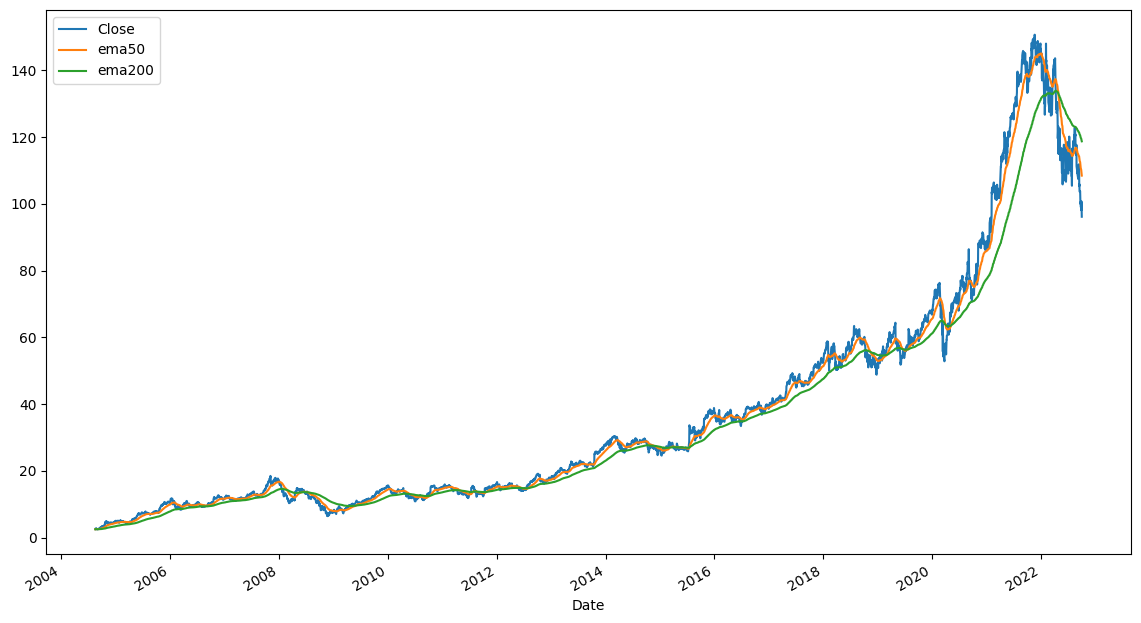

In [504]:
df[['Close','ema50','ema200']].plot(figsize=(14,8))

### Feature selection

In [505]:
#create a new dataframe with new column
dff = df.filter(['Close'])

#Converting to array
df1 = dff.values

In [506]:
#Get the number of rows to train the model  
train_size = math.ceil(len(df1)*0.8)
train_size

3650

### Data Preprocessing
LSTM are sensitive to the scale of the data. so we are applying MinMax scaler 

In [507]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df1)

In [508]:
#Create Training data set
#Create the scaled training dataset
train_data = scaled_data[0:train_size,:]

In [509]:
#Splitting the data into X_train, y_train
x_train = []
y_train = []
time_step = 100
for i in range(time_step,len(train_data)):
    x_train.append(train_data[i-time_step:i,0])
    y_train.append(train_data[i, 0])

In [510]:
x_train,y_train = np.array(x_train),np.array(y_train)
#reshape the data
#LSTM MODel expects the data in 3D in form of sample,timesteps and number of feature
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(3550, 100, 1)

### LSTM model creation

In [511]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(75,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

### Training the model

In [512]:

model.fit(x_train,y_train,batch_size=1,epochs=1)
model.reset_states()

3550/3550 [==============================] - 129s 36ms/step - loss: 1.8717e-04


In [513]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 100, 75)           23100     
                                                                 
 lstm_21 (LSTM)              (None, 50)                25200     
                                                                 
 dense_20 (Dense)            (None, 25)                1275      
                                                                 
 dense_21 (Dense)            (None, 1)                 26        
                                                                 
Total params: 49,601
Trainable params: 49,601
Non-trainable params: 0
_________________________________________________________________


### Testing the model

In [514]:
#Create the testing dataset
test_data = scaled_data[train_size-time_step:,:]

In [515]:
#Create the data sets x_tests and y_test
x_test = []
y_test = df1[train_size:,:]
for i in range(time_step,len(test_data)):
    x_test.append(test_data[i-time_step:i,0])

#convert the data to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [516]:
#get the model predicted value
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

29/29 [==============================] - 2s 30ms/step


### Model Evaluation

In [517]:
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(y_test, predict), 2))
print("Root Mean squared error(RMSE) =", round(np.sqrt(sm.mean_squared_error(y_test, predict)), 2))
print("R2 score =", round(sm.r2_score(y_test, predict), 2))

Mean absolute error(MAE) = 2.52
Root Mean squared error(RMSE) = 3.39
R2 score = 0.99


#### Dumping model h5 file for UI purpose.

In [518]:
model.save('model.h5')

### Prediction on New stocks

C:\Users\Vishal Khetmalis\AppData\Local\Temp\ipykernel_14868\4119608193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = predict


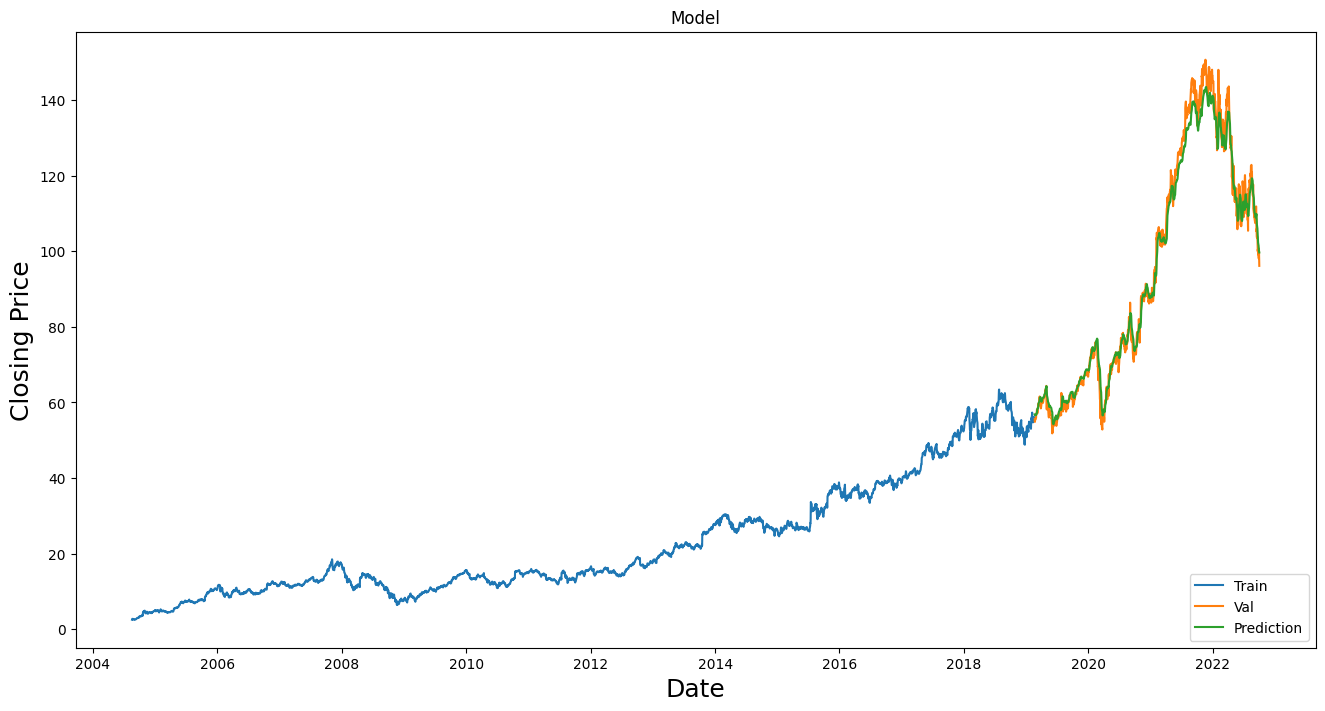

In [519]:
#plot the data
train = dff[:train_size]
valid = dff[train_size:]
valid['Prediction'] = predict

#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Prediction']])
plt.legend(['Train','Val','Prediction'],loc='lower right')
plt.show()

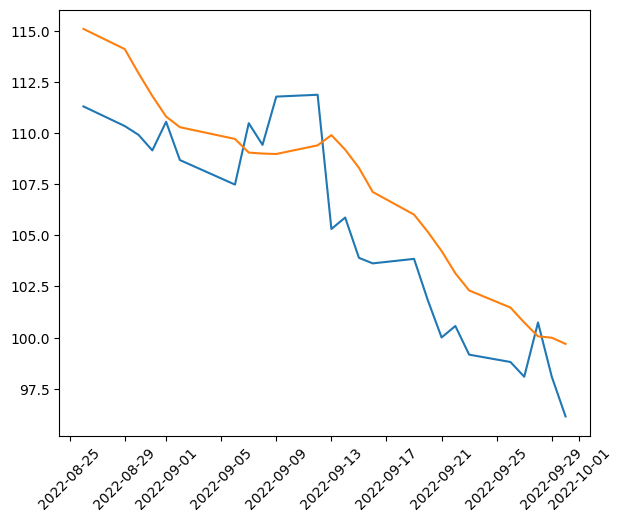

In [520]:
plt.plot(valid.tail(25)[['Close','Prediction']])
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [521]:
#l=input("Enter date1")
#m=input('d2')
df5 = pdr.get_data_yahoo(input("Enter Stock Symbol : "))

df_close = df5.filter(['Close'])

last_time_step_days = df_close[-time_step:].values

last_time_step_days_scaled = scaler.transform(last_time_step_days)

x_test = []

x_test.append(last_time_step_days_scaled)
x_test = np.array(x_test)

x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

pred_price = model.predict(x_test)
model.reset_states()

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

1/1 [==============================] - 0s 36ms/step
[[99.04593]]


In [522]:
n_steps = 100
len(test_data)

1012

In [523]:
pred_days = int(input("Enter number of days pred needed : "))

In [524]:
x_input = test_data[len(test_data)-n_steps:].reshape(1,-1)
x_input.shape

(1, 100)

In [525]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
len(temp_input)

100

In [526]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output = []
i = 0
while(i<pred_days):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1 
print(lst_output)

[0.65143883]
101
1 day input [0.75206804 0.74667062 0.76930281 0.75767805 0.77055769 0.74154302
 0.73037366 0.72070888 0.73658746 0.69785741 0.69727379 0.71384732
 0.74422827 0.75259431 0.75325549 0.77760476 0.7561364  0.77264245
 0.77412001 0.77417735 0.75852474 0.73497498 0.70427026 0.70641235
 0.72797856 0.70264764 0.71094285 0.73893874 0.73906691 0.74345575
 0.78294823 0.77002468 0.74269337 0.7405681  0.72111027 0.7191436
 0.75156879 0.76051844 0.78812977 0.79394892 0.76935001 0.75806261
 0.74009917 0.73505934 0.74401234 0.72473672 0.75651422 0.75705392
 0.75934787 0.71427914 0.71326711 0.69457845 0.74963244 0.75631177
 0.77014276 0.76231648 0.76515013 0.78458094 0.78518818 0.78080274
 0.78026298 0.77594503 0.7971975  0.79159763 0.81069113 0.81224287
 0.80974658 0.79497104 0.79861433 0.78012807 0.75955026 0.7575262
 0.75705392 0.77729437 0.73411479 0.72763781 0.72473672 0.71960913
 0.72905468 0.71643812 0.70834196 0.72858241 0.72143075 0.73735324
 0.73796048 0.69370134 0.69747959 0

In [527]:
print(lst_output)

[[0.65143883228302], [0.6503807902336121], [0.6503739356994629], [0.6508049368858337], [0.6513752341270447], [0.6519473791122437], [0.6524618268013], [0.6528974175453186], [0.6532520055770874], [0.6535331010818481], [0.6537516117095947], [0.6539195775985718], [0.6540489792823792], [0.6541501879692078], [0.6542320251464844], [0.6543012857437134], [0.6543636322021484], [0.6544226408004761], [0.6544812321662903], [0.654541015625], [0.6546029448509216], [0.6546673774719238], [0.654734194278717], [0.6548030376434326], [0.6548738479614258]]


In [528]:
day_new = np.arange(1,61)
day_pred = np.arange(61,61+pred_days)
day_pred

array([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85])

In [529]:
scaler.inverse_transform(lst_output)

array([[99.04593025],
       [98.88910928],
       [98.88809332],
       [98.95197549],
       [99.03650385],
       [99.12130609],
       [99.19755654],
       [99.26211897],
       [99.31467533],
       [99.35633876],
       [99.38872599],
       [99.41362157],
       [99.43280124],
       [99.4478022 ],
       [99.45993195],
       [99.47019763],
       [99.4794385 ],
       [99.48818464],
       [99.49686894],
       [99.50572993],
       [99.51490896],
       [99.52445904],
       [99.5343625 ],
       [99.54456633],
       [99.5550617 ]])

In [530]:
len(df1)

4562

In [531]:
df3=df1
df3=pd.DataFrame(df3,columns=['Price'])
df3

,Price
0,2.499133
1,2.697639
2,2.724787
3,2.611960
4,2.640104
...,...
4557,98.809998
4558,98.089996
4559,100.739998
4560,98.089996


In [532]:
predictions = scaler.inverse_transform(lst_output)
predictions = pd.DataFrame(predictions,columns=['Close'])

In [533]:
df_pred=df3.append(predictions)

C:\Users\Vishal Khetmalis\AppData\Local\Temp\ipykernel_14868\148780041.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred=df3.append(predictions)


In [534]:
predictions.tail()

,Close
20,99.514909
21,99.524459
22,99.534363
23,99.544566
24,99.555062


In [535]:
p = datetime.now()+timedelta(days = pred_days-1)
predictions['Date'] = pd.date_range(datetime.now(),p)
predictions['Date']

0    2022-10-02 15:36:25.719821
1    2022-10-03 15:36:25.719821
2    2022-10-04 15:36:25.719821
3    2022-10-05 15:36:25.719821
4    2022-10-06 15:36:25.719821
5    2022-10-07 15:36:25.719821
6    2022-10-08 15:36:25.719821
7    2022-10-09 15:36:25.719821
8    2022-10-10 15:36:25.719821
9    2022-10-11 15:36:25.719821
10   2022-10-12 15:36:25.719821
11   2022-10-13 15:36:25.719821
12   2022-10-14 15:36:25.719821
13   2022-10-15 15:36:25.719821
14   2022-10-16 15:36:25.719821
15   2022-10-17 15:36:25.719821
16   2022-10-18 15:36:25.719821
17   2022-10-19 15:36:25.719821
18   2022-10-20 15:36:25.719821
19   2022-10-21 15:36:25.719821
20   2022-10-22 15:36:25.719821
21   2022-10-23 15:36:25.719821
22   2022-10-24 15:36:25.719821
23   2022-10-25 15:36:25.719821
24   2022-10-26 15:36:25.719821
Name: Date, dtype: datetime64[ns]

In [536]:
ppp = predictions.set_index('Date')
ppp

,Close
Date,
2022-10-02 15:36:25.719821,99.045930
2022-10-03 15:36:25.719821,98.889109
2022-10-04 15:36:25.719821,98.888093
2022-10-05 15:36:25.719821,98.951975
2022-10-06 15:36:25.719821,99.036504
2022-10-07 15:36:25.719821,99.121306
2022-10-08 15:36:25.719821,99.197557
2022-10-09 15:36:25.719821,99.262119
2022-10-10 15:36:25.719821,99.314675


In [537]:
df_date = df['Close']
df_date = pd.DataFrame(df_date)

In [538]:
df_date=df_date.append(ppp)

C:\Users\Vishal Khetmalis\AppData\Local\Temp\ipykernel_14868\315424664.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date=df_date.append(ppp)


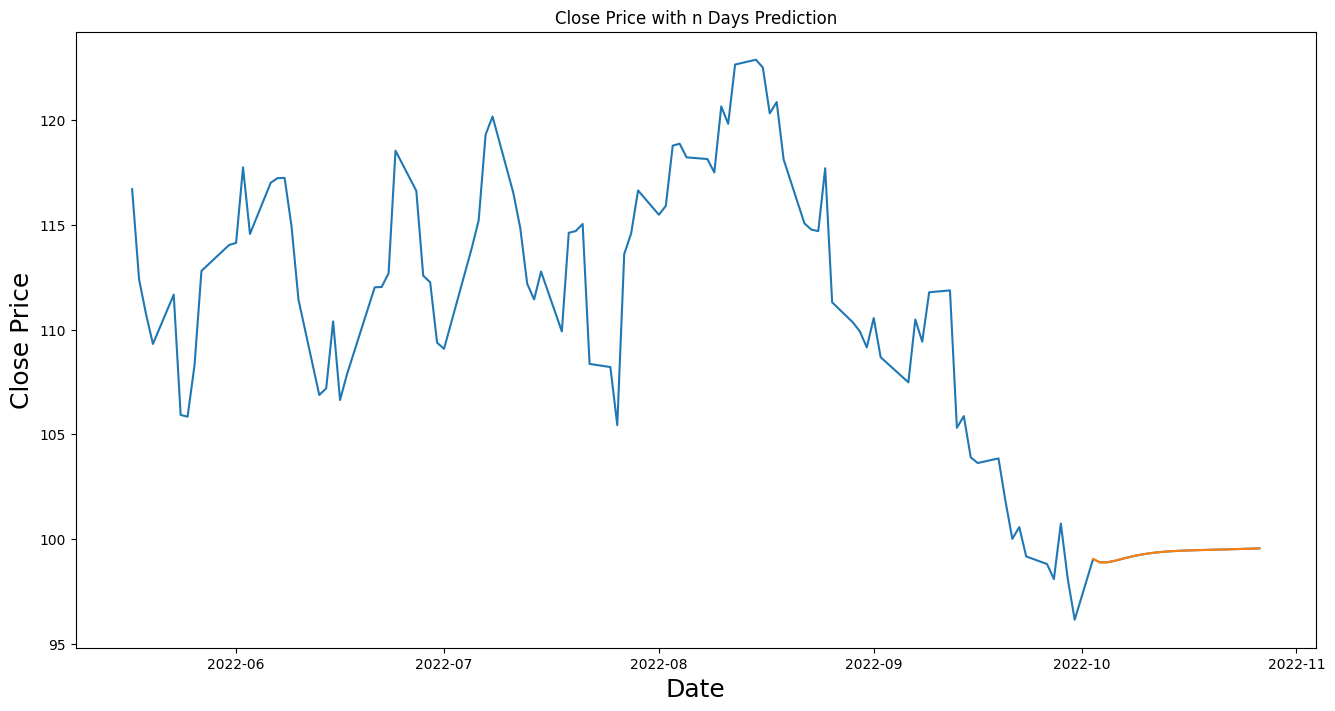

In [539]:
plt.figure(figsize=(16,8))
plt.title('Close Price with n Days Prediction')
plt.plot(df_date['Close'].tail(120))
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.plot(ppp)
plt.show()